_To use this notebook you must have a (free) FEO account, available [here](https://feo.transitionzero.org/). You may then install the feo-client library, if necessary, and then use the package to log in. You can also run notebook in a Colab notebook via the badge below._

<a target="_blank" href="https://colab.research.google.com/github/transition-zero/feo-client-examples/blob/main/feo-client-examples/0_nodes.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ feo-client

In [2]:
from feo.client.auth import login

login()

1. In a browser navigate to:  https://dev-feo-tz.eu.auth0.com/activate?user_code=GWNC-FWKB
2. Enter the following code:  GWNC-FWKB
Checking for authentication.Authenticated!
- Id Token: eyJhbGciOi...


## Geospatial

_Object-oriented interface for Nodes via the Python client_

FEO comprises a wide variety of geospatial data, covering vector and raster data types. Vector types include `node geometries`, `hydrobasins`, `exclusive economic zones` and `protected areas`. Each of these exists as a `Collection` that can be browsed and searched via several methods.

In this notebook we will gather some vector data for a node, namely:
- The node geometry
- The protected areas intersecting the node geometry
- Any corresponding offshore areas (Exclusive Economic Zones)

In [2]:
from feo.client import Node, Features

In [3]:
# Let's use Bali
node_name = "Bali"
nodes = Node.search(node_name)
try:
    bali = nodes[0]
    print(bali)
except IndexError:
    raise IndexError(f"No nodes found for {node_name}")

id='IDN-BA' node_type='admin_1' type_alias='province' name_primary_en='Bali' public=True is_asset=False properties=None sector=None asset_properties=None


In [4]:
bali_geom = bali.geometry

In [5]:
type(bali_geom)

feo.client.geospatial.Geometry

The `geometry` property is a `Geometry` class. This class provides convenience methods for downstream purposes. In the base `feo-client` install you can convert the geometry to a dictonary or a GeoJSON string

In [6]:
print(bali_geom.to_geojson()[:100]) # sliced to limit output

{"type":"MultiPolygon","coordinates":[[[[115.525726,-8.804456],[115.525375,-8.804235],[115.525749,-8


If you installed the `geo` requirements you'll be able to also use the `to_shape` method to return a `shapely.Geometry` object.

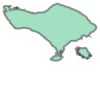

In [7]:
bali_geom.to_shape()

### Search for other vector data
Next we'll search for any protected areas located within Bali.

In [8]:
# Search for Protected Areas
pa_feats = Features.search(collection_id="biodiversity-wdpa", geometry=bali_geom)

`pa_feats` is a `Features` objects; a collection of features, each with properties and a geometry

In [9]:
# How many protected areas were returned?
len(pa_feats.features)

8

In [10]:
# Examine a feature

In [11]:
ft = pa_feats.features[0]
ft.properties

{'iso3': 'IDN',
 'name': 'Ngurah Rai',
 'datetime': '2023-09-30',
 'wdpa_pid': '101824',
 'designation': 'Grand Forest Park',
 'designation_type': 'National'}

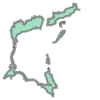

In [12]:
ft.geometry.to_shape()

If you have the `geo` dependencies installed you can convert the `Features` object to a `GeoDataFrame`

In [13]:
gdf = pa_feats.to_geodataframe()
gdf

,iso3,name,datetime,wdpa_pid,designation,designation_type,geometry
0,IDN,Ngurah Rai,2023-09-30,101824,Grand Forest Park,National,"MULTIPOLYGON (((115.21741 -8.77034, 115.21735 ..."
1,IDN,Bali Barat,2023-09-30,1268,National Park,National,"MULTIPOLYGON (((114.48476 -8.15995, 114.48468 ..."
2,IDN,Danau Buyan - Danau Tamblingan,2023-09-30,17922,Nature Recreation Park,National,"MULTIPOLYGON (((115.13132 -8.25170, 115.13142 ..."
3,IDN,Batukahu I-II-III,2023-09-30,1910,Nature Reserve,National,"MULTIPOLYGON (((115.13956 -8.28906, 115.13987 ..."
4,IDN,Gunung Batur Bukit Payang,2023-09-30,555571228,Nature Recreation Park,National,"MULTIPOLYGON (((115.38834 -8.23035, 115.38835 ..."
5,IDN,KKP NUSA PENIDA,2023-09-30,555587241,Marine Recreation Park,National,"MULTIPOLYGON (((115.58047 -8.65981, 115.66149 ..."
6,IDN,Sangeh,2023-09-30,62491,Nature Recreation Park,National,"MULTIPOLYGON (((115.20704 -8.47867, 115.20761 ..."
7,IDN,Panelokan,2023-09-30,8757,Nature Recreation Park,National,"MULTIPOLYGON (((115.36262 -8.28218, 115.36270 ..."


### Visualise the data
`Features` and `Geometry` objects both have GeoJSON representations, allowing for easy interoperability with other geospatial tools. In this example, we use `folium` to plot an interactive map of Bali and its protected areas.

In [ ]:
!pip install folium

In [14]:
import folium
from folium.features import GeoJson

In [15]:
# Define the layer styles
bali_style = {"fillColor": "#f2ff00", "color": "#f2ff00"}
pa_style = {'fillColor': '#000000', 'color': '#000000'}

In [16]:
bali_geom_shape = bali_geom.to_shape() # convert our Geometry object to a shapely object
map_center = bali_geom_shape.centroid # access the centroid using the shape property

# Configure the map
map = folium.Map(location=(map_center.y, map_center.x), zoom_start=10)

# Add vector data to the map via the GeoJSON interface
map.add_child(GeoJson(bali_geom.to_geojson(), name="Bali", style_function=lambda x: bali_style))
map.add_child(GeoJson(pa_feats.to_geojson(), name="World Database on Protected Areas",
                      style_function=lambda x: pa_style,
                      popup=folium.GeoJsonPopup(fields=["name", "designation"]))
)
folium.LayerControl().add_to(map)
map